# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Это задание посвящено линейной регрессии (прогнозирование роста человека по его весу)

##  Задание 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные SOCR по росту и весу 25 тысяч подростков.


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
%matplotlib inline

Считаем данные по росту и весу (weights_heights.csv, приложенный в задании) в объект Pandas DataFrame:

In [0]:
data = pd.read_csv('https://d3c33hcgiwev3.cloudfront.net/_0c048aa6ba23f280b723d66fb0660b43_weights_heights.csv?Expires=1563580800&Signature=DUG3RbDxdJm~GDO5CE6qAjmjyfyc~Zpc3bfjHsi83p4NIFqQQRD7AD4TZ-3dux6S1oLuJsrXWp6Fty6LUHOUTPrcbt9lns9RolCc2SH8SrY49lbylqe4P0UfBceAzMh8i43ro8~tdI~6LPZQIIi5KIS1cKia9s~lo9mib2W2SzQ_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A', index_col='Index')

Посмотрите на первые 5 записей с помощью метода head Pandas DataFrame.

In [3]:
data.head()  # по умолчанию - 5

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


Построим гистограмму распределения роста подростков из выборки data

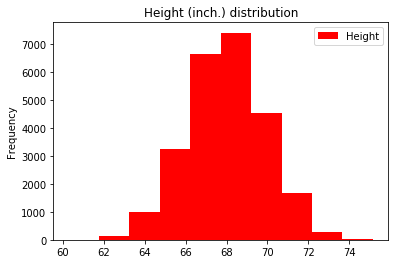

In [4]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

 Нарисуем гистограмму распределения веса 

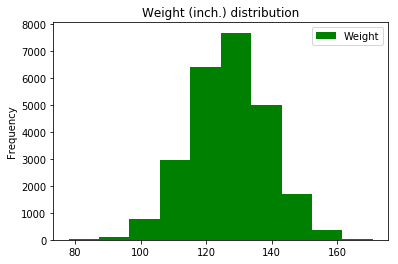

In [5]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Weight (inch.) distribution')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается  m×m  графиков (m - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков.  

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак Индекс массы тела (BMI). Для этого воспользуемся удобной связкой метода apply Pandas DataFrame и lambda-функций Python.

In [0]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [7]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)
data.head()

,Height,Weight,BMI
Index,,,
1,65.78331,112.9925,18.357573
2,71.51521,136.4873,18.762577
3,69.39874,153.0269,22.338895
4,68.21660,142.3354,21.504526
5,67.78781,144.2971,22.077581


Построим попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга

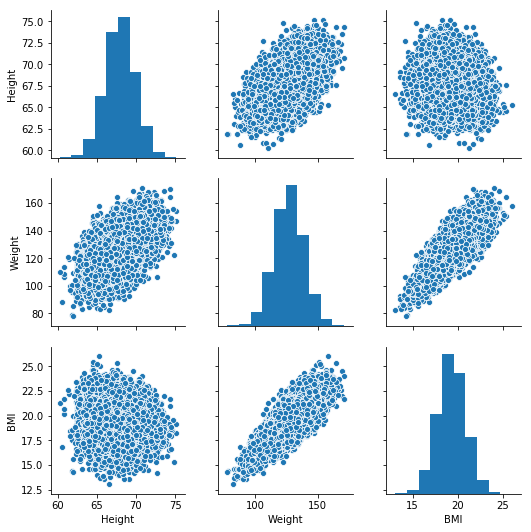

In [8]:
sns.pairplot(data)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального. В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других.  

Создадим новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях.

In [9]:
def weight_category(weight):
    return 1 if weight < 120 else (3 if weight >= 150 else 2)


data['weight_cat'] = data['Weight'].apply(weight_category)
data.head()

,Height,Weight,BMI,weight_cat
Index,,,,
1,65.78331,112.9925,18.357573,1
2,71.51521,136.4873,18.762577,2
3,69.39874,153.0269,22.338895,3
4,68.21660,142.3354,21.504526,2
5,67.78781,144.2971,22.077581,2


Построим «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории

[Text(0, 0.5, 'Рост'), Text(0.5, 0, 'Весовая категория')]

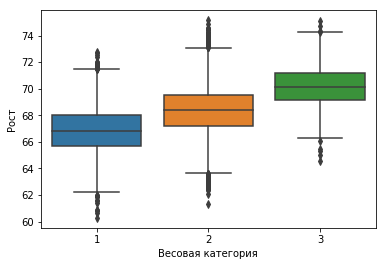

In [10]:
ax = sns.boxplot(x="weight_cat", y="Height", data=data)
ax.set(xlabel='Весовая категория', ylabel='Рост')

Построим scatter plot зависимости роста от веса

Text(0.5, 1.0, 'Зависимость роста от веса')

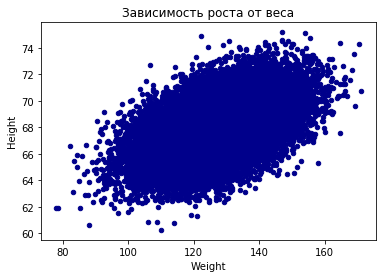

In [11]:
ax1 = data.plot(x='Weight', y='Height',  kind='scatter', c='DarkBlue')
ax1.set_title('Зависимость роста от веса')

##  Задание 2. Минимизация квадратичной ошибки  

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки

Напишите функцию, которая по двум параметрам  w0  и  w1  вычисляет квадратичную ошибку приближения зависимости роста  y  от веса  x  прямой линией $y = w_{0} + w_{1}\cdot x$  
$$fun\_error(w_{0}, w_{1}) =\sum\limits_{i=1}^n (y_{i} - (w_{0} + w_{1}\cdot x))^2 $$  

Здесь  n  – число наблюдений в наборе данных,  yi  и  xi  – рост и вес  i -ого человека в наборе данных

In [0]:
def func(w0, w1, x):
    return (w0 + w1*x)

# quadratic error function
def qdrtErr (w0, w1):       
    return sum([
        (data['Height'][i] - func(w0, w1, data['Weight'][i]))**2 
        for i in range(1, len(data))
    ])

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6.   
Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.    
Для этого проведем  на графике рост/вес  две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$.

In [0]:
def draw_model_plot(w_values):
    ax = data.plot(kind = 'scatter', x = 'Weight', y = 'Height', title = 'Зависимость роста от веса')
    ax.set(xlabel = 'Вес', ylabel = 'Рост')
    
    start = data['Weight'].min()
    end = data['Weight'].max()
    tempX = np.linspace(start, end)
    colors = ['red', 'green', 'blue', 'black', 'orange']
    
    for w in w_values:
      color = colors.pop()
      plt.plot(tempX, func(w[0], w[1], tempX), color=color, label='w0, w1= '+str(w))
      
    plt.legend(loc='best')

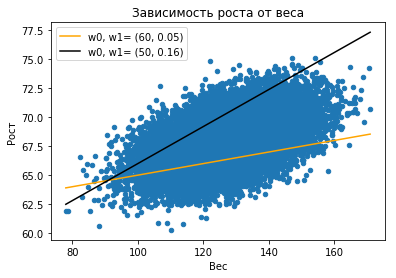

In [14]:
draw_model_plot([(60, 0.05), (50, 0.16)])

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации.   
Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.  
Построим график зависимости функции ошибки, посчитанной в ранее, от параметра  $w_{1}$  при $ w_{0}$  = 50

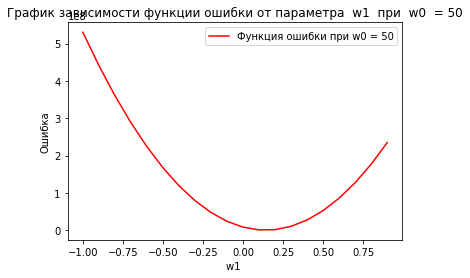

In [15]:
#значения w1 возьмем в диапазоне между предложенными значениями в предыдущем задании
w_arr = np.arange(-1, 1, 0.1)
plt.plot(w_arr, [qdrtErr(50, w1) for w1 in w_arr], color='red', 
         label='Функция ошибки при w0 = 50')
plt.title('График зависимости функции ошибки от параметра  w1  при  w0  = 50')
plt.xlabel('w1 ')
plt.ylabel('Ошибка')
plt.legend(loc='best')

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте  $w_{0}=50 $.

С помощью метода minimize_scalar из scipy.optimize найдем минимум функции ошибки, для значений параметра  $w_{1} $ в диапазоне [-5,5].   


In [16]:
w1_opt = minimize_scalar(lambda w1: qdrtErr(50, w1),(0,0), bounds=(-5,5), method = 'bounded').x
print('Оптимальное значение параметра w1: {}'.format(w1_opt))

Оптимальное значение параметра w1: 0.14109165115062905


Посмотрим насколько хорошо восстанавливает зависимость прямая соответствующая значениям параметров  $(w_0, w_1)$ = (50,  w1_opt )

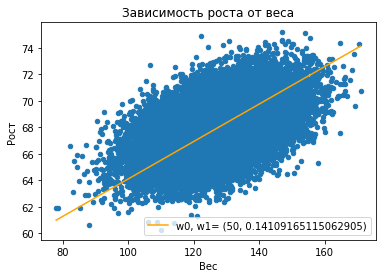

In [17]:
draw_model_plot([(50, w1_opt)])

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты и отображают данные на плоскости или в объеме.

Посмотрим, как в Python рисовать 3D картинки, на примере отображения функции    для значений    и    из интервала [-5,5] c шагом 0.25.

In [0]:
from mpl_toolkits.mplot3d import Axes3D

Построим 3D-график зависимости функции ошибки, посчитаннойранее от параметров  $(w_0, w_1)$  

Создаем объекты типа matplotlib.figure.Figure (рисунок) и matplotlib.axes._subplots.Axes3DSubplot (ось)

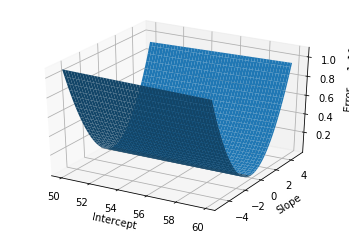

In [19]:
 
fig = plt.figure()
ax = fig.gca(projection='3d')

w0 = np.arange(50, 60, 0.1)
w1 = np.arange(-5, 5, 0.1)
w0, w1 = np.meshgrid(w0, w1)
Z = qdrtErr(w0, w1)

surf = ax.plot_surface(w0, w1, Z)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

С помощью метода minimize из scipy.optimize найдем минимум функции ошибки при $w_0 $  в диапазоне [-100,100]  и   $ w_1$ - в диапазоне [-5, 5]. Начальная точка – ( $w_0 $ ,  $ w_1$ ) = (0, 0). Используем метод оптимизации L-BFGS-B (аргумент method метода minimize).   

In [0]:
min_err = minimize(lambda w: qdrtErr(w[0],w[1]), x0 = (0, 0), bounds = ((-100., 100.),(-5., 5.)), method = 'L-BFGS-B').x

[57.57169072  0.08200688]


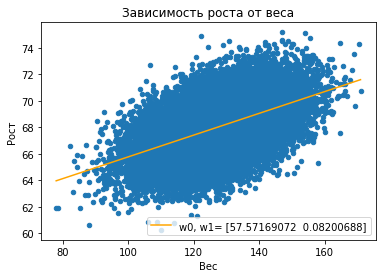

In [25]:
print(min_err)
draw_model_plot([min_err])